## This is starter code for single point prediction with CNNs

In [1]:
import os

# common math imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# common torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# common sklearn imports 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load and process data

In [2]:
# tensor data
X = torch.load('data/bc22-32/X_rnn_tensor.pt')
y = torch.load('data/bc22-32/y_rnn_tensor.pt')
y = y.to(torch.float)

# meta data information
filtdata = pd.read_csv('data/bc22-32/train_metadata_nuanced.csv')
common = np.loadtxt('data/bc22-32/common_species.txt', dtype=str)[-5:]
files = np.loadtxt('data/bc22-32/files_rnn.csv', dtype=str)

# print the shapes of the data
filtdata.shape, len(files), X.shape, y.shape

((13842, 48), 22793, torch.Size([22793, 10, 32, 50]), torch.Size([22793, 10]))

In [3]:
# Analyze common species only
filtdata_v2 = filtdata[filtdata['primary_label'].isin(common)]
common_labels = filtdata_v2['filename'].unique()
files_v2 = ['/'.join(file.split('/')[2:]) for file in files]
bools = np.isin(files_v2, common_labels)
X2 = X[bools]
y2 = y[bools]
X2.shape, y2.shape

(torch.Size([1593, 10, 32, 50]), torch.Size([1593, 10]))

In [40]:
# Because the common species don't have 1 - 10 labels
# Get unique values and create mapping
unique_vals = torch.unique(y2)
val_to_new = {old.item(): new for new, old in enumerate(unique_vals)}
label_map = val_to_new

# Remap y2 using the mapping
y2_mapped = torch.tensor([[label_map[val.item()] if val.item() in label_map else -1 for val in row] for row in y2])

## Set up a convolutional recurrent model class

In [ ]:
class CRNN(nn.Module):
    """
    Convolutional Recurrent Neural Network (CRNN) for sequence classification.
    """

    def __init__(self, 
                 num_classes,
                 height=32,
                 width=50,
                 kernel_sizes=[3,3,3],
                 padding_sizes=[1,1,1],
                 stride_sizes=[1,1,1],
                 pooling_kernels=[(1,4),(1,2),(2,2)],
                 pooling_strides=[(1,4),(1,2),(2,2)],
                 channel_sizes=[16,16,16], 
                 num_rnn_hidden=32, 
                 num_rnn_layers=1,
                 num_fc_hidden=32, 
                 leakyRelu=False, 
                 batchNormalization=True):
        """Initializes the CRNN model.

        Parameters
        ----------
        num_classes : int
            Number of output classes.
        height : int, optional
            Height of the input images, by default 32
        width : int, optional
            Width of the input images, by default 50
        kernel_sizes : list, optional
            List of kernel sizes for each convolutional layer, by default [3,3,3]
        padding_sizes : list, optional
            List of padding sizes for each convolutional layer, by default [1,1,1]
        stride_sizes : list, optional
            List of stride sizes for each convolutional layer, by default [1,1,1]
        pooling_kernels : list, optional
            List of pooling kernel sizes for each pooling layer, by default [(1,4),(1,2),(2,2)]
        pooling_strides : list, optional
            List of pooling strides for each pooling layer, by default [(1,4),(1,2),(2,2)]
        channel_sizes : list, optional
            List of output channel sizes for each convolutional layer, by default [16,16,16]
        num_rnn_hidden : int, optional
            Number of hidden units in the RNN layer, by default 32
        num_rnn_layers : int, optional
            Number of layers in the RNN, by default 1
        num_fc_hidden : int, optional
            Number of hidden units in the fully connected layer, by default 32
        leakyRelu : bool, optional
            Whether to use LeakyReLU activation, by default False
        batchNormalization : bool, optional
            Whether to apply batch normalization after convolutional layers, by default True
        
        Returns
        -------
        None
        """
        super(CRNN, self).__init__()

        ks = kernel_sizes
        ps = padding_sizes
        ss = stride_sizes
        nm = channel_sizes
        assert len(ks) == len(ps) == len(ss) == len(nm) 

        # define the CNN layers
        cnn = nn.Sequential()
        nIn = 1
        out_height, out_width = height, width
        for i in range(len(nm)):
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            # Calculate output height and width after this conv layer
            out_height = (out_height + 2 * ps[i] - ks[i]) // ss[i] + 1
            out_width = (out_width + 2 * ps[i] - ks[i]) // ss[i] + 1
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))
            pooling_kernel = pooling_kernels[i]
            pooling_stride = pooling_strides[i]
            cnn.add_module('pooling{0}'.format(i), nn.MaxPool2d(pooling_kernel, pooling_stride))
            # Update output height and width after pooling
            out_height = (out_height - pooling_kernel[0]) // pooling_stride[0] + 1
            out_width = (out_width - pooling_kernel[1]) // pooling_stride[1] + 1
            nIn = nOut

        self.cnn = cnn
        self.rnn = nn.LSTM(nm[-1] * out_height * out_width, 
                           num_rnn_hidden,
                           num_layers=num_rnn_layers, 
                           bidirectional=True,
                           batch_first=True,
                           )
        self.fc1 = nn.Linear(num_rnn_hidden * 2, num_fc_hidden * 2)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(num_fc_hidden * 2, num_classes)

    def forward(self, input):
        """Forward pass of the CRNN model.

        Parameters
        ----------
        input : torch.Tensor
            Input tensor of shape (batch_size, time_steps, channels, height, width).

        Returns
        -------
        torch.Tensor
            Output tensor of shape (batch_size, time_steps, num_classes).
        """

        # conv features
        b, t, c, h, w = input.size()
        x = input.view(-1, c, h, w)
        x = self.cnn(x)
        x = x.view(b, t, -1)

        # rnn features
        # Initialize hidden and cell states for LSTM
        h0 = torch.zeros(self.rnn.num_layers * 2, b, self.rnn.hidden_size, device=x.device)
        c0 = torch.zeros(self.rnn.num_layers * 2, b, self.rnn.hidden_size, device=x.device)
        out, _ = self.rnn(x, (h0, c0))
        
        # # fully connected layer
        out = self.fc1(out)
        out = self.relu_fc(out)
        out = self.fc2(out)

        return out

## Train-test split

In [43]:
batch_size = 100
num_zeros = 100

X2 = X2.to(torch.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X2, y2_mapped, test_size=0.2, random_state=42
)

# Print the sizes of the splits
print(f"Training data size: {X_train.shape[0]}")
print(f"Testing data size: {X_test.shape[0]}")

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Training data size: 1274
Testing data size: 319


## Initialize the model

In [54]:
# Example usage
num_classes = len(y2_mapped.unique())  # Number of unique categories in y_encoded
crnn_model = CRNN(num_classes)
# crnn_model.half()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification

# Choose an optimizer for training
# optimizer = optim.SGD(crnn_model.parameters(), lr=0.01, momentum=0.9)  # Adjust learning rate and momentum as needed
optimizer = optim.Adam(crnn_model.parameters(), lr=0.002)  # You can adjust the learning rate
# optimizer = optim.RMSprop(crnn_model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False) # I know less about these


def count_parameters(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

print("CNN parameters:", count_parameters(crnn_model.cnn))
print("RNN parameters:", count_parameters(crnn_model.rnn))
print("FC1 parameters:", count_parameters(crnn_model.fc1))
print("FC2 parameters:", count_parameters(crnn_model.fc2))

print()

print(crnn_model)


CNN parameters: 1896
RNN parameters: 7040
FC1 parameters: 544
FC2 parameters: 198

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

## Train the model

In [59]:
# # Training loop
num_epochs = 20  # Number of epochs to train
for epoch in range(num_epochs):
    crnn_model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        inputs = inputs.unsqueeze(2)  # Add channel dimension
        # inputs = inputs.half().to("cpu")  # Convert to half precision
        outputs = crnn_model(inputs)
        
        # Reshape for CrossEntropyLoss: (batch*time, num_classes) vs (batch*time,)
        outputs = outputs.reshape(-1, num_classes)
        labels = labels.reshape(-1).long()

        # Compute the loss
        # And backpropagate
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(crnn_model.parameters(), max_norm=1.0, norm_type=2)
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1/20, Loss: 1.0365
Epoch 2/20, Loss: 0.9890
Epoch 3/20, Loss: 0.9728
Epoch 4/20, Loss: 0.9837
Epoch 5/20, Loss: 0.9310
Epoch 6/20, Loss: 0.9680
Epoch 7/20, Loss: 0.9283
Epoch 8/20, Loss: 0.9960
Epoch 9/20, Loss: 0.9216
Epoch 10/20, Loss: 0.9296
Epoch 11/20, Loss: 0.9249
Epoch 12/20, Loss: 0.8798
Epoch 13/20, Loss: 0.8799
Epoch 14/20, Loss: 0.8687
Epoch 15/20, Loss: 0.8570
Epoch 16/20, Loss: 0.8984
Epoch 17/20, Loss: 0.8626
Epoch 18/20, Loss: 0.8531
Epoch 19/20, Loss: 0.8422
Epoch 20/20, Loss: 0.8393


## Evaluate the model

In [56]:
# Evaluate the model's accuracy on the training data
crnn_model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in train_loader:

        # Forward pass
        inputs = inputs.unsqueeze(2)
        outputs = crnn_model(inputs)
        outputs = outputs.reshape(-1, num_classes)
        predicted = outputs.argmax(dim=1)
        labels = labels.reshape(-1).long()

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = correct / total * 100
print("CNN model")
print(f"Training Accuracy: {accuracy:.2f}%")

CNN model
Training Accuracy: 11.96%


In [57]:
# Evaluate the model's accuracy on the training data
crnn_model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in test_loader:

        # Forward pass
        inputs = inputs.unsqueeze(2)
        outputs = crnn_model(inputs)
        outputs = outputs.reshape(-1, num_classes)
        predicted = outputs.argmax(dim=1)
        labels = labels.reshape(-1).long()

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print the accuracy
accuracy = correct / total * 100
print("CNN model")
print(f"Test Accuracy: {accuracy:.2f}%")

CNN model
Test Accuracy: 11.94%


## Plot the confusion matrix

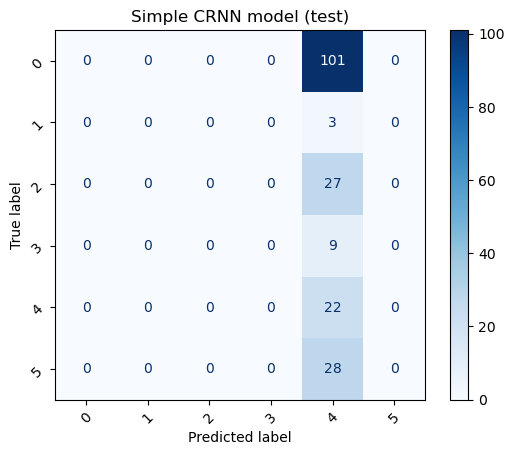

In [58]:
# Collect all predictions and true labels
all_predictions = []
all_true_labels = []

# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y2_mapped)

crnn_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for evaluation
    for inputs, labels in test_loader:

        # Forward pass
        inputs = inputs.unsqueeze(2)
        outputs = crnn_model(inputs)
        outputs = outputs.reshape(-1, num_classes)
        predicted = outputs.argmax(dim=1)
        labels = labels.reshape(-1).long()

# Compute the confusion matrix
cm = confusion_matrix(labels, predicted)

# Display the confusion matrix
# Invert numeric labels back to bird_names for display
disp_labels = [c.split('/')[0] for c in np.unique(common_labels)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.title('Simple CRNN model (test)')

plt.show()